# **Задание**

- Выполните задание по ссылке и оформите в виде CRISP-DM подхода.
- Структурируйте код, отчёт и файлы с данными на основе сегодняшней лекции.
- Загрузите решение в Git и пришлите ссылку на ваш репозиторий.
- Дополнительное задание* Попробуйте не загружать CSV-файл с данными, а сделайте отдельный скрипт на его получение.


# **Решение**

In [1]:
!pip install tensorflow

In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

import keras.models
import tensorflow as tf
from scikeras.wrappers import KerasRegressor, KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

import pickle

**Попробуйте не загружать CSV-файл с данными, а сделайте отдельный скрипт на его получение.**

In [ ]:
# используем kaggle token хранящийся на пк для скачки данных с kaggle в качестве альтернативы глобальной переменной
!pip install opendatasets
!python Download_kaggle_dataset_script.py

Skipping, found downloaded files in "/content/wine-quality" (use force=True to force download)


In [ ]:
df = pd.read_csv("/content/wine-quality/winequalityN.csv")

В разрезе CRISP-DM подхода

1. На этапе бизнес-анализа сформулируем задачу.

Исходя из предоставленных к исследовнию данных мы хотим научиться разбираться в качестве вина исходя из его физико-химических показателей. Качество вина измеряем в баллах по 10 бальной шкале. Имеем размеченный датасет в котором в качестве объектов какие-то уникальные образцы вин. В качестве признаков имеем около десятка характеристик состава вин плюс целевой признак - установленное качество вина. На выходе ожидаем получить модель способную определить качество вина по его характеристикам

2. Анализ данных EDA:

In [ ]:
df.shape

(6497, 13)

Имеем 6497 объектов и 13 признаков включая целевой

In [ ]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Целевой признак является дискретным и выражается целым числом соответствующим оценке качества вина

Среди предикторных признаков есть категориальные и числовые.
Категориальный признак один и выражается текстом - Тип вина
Все остальные признаки числовые и выражются непрерывными величинами числами с плавающей точкой.

Есть пропущенные значения.

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


У всех признаков разный масштаб данных. Потребуется нормализация.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Видим, что пропущенные значения есть  в 6 из 13 столбцов.

**3. Подготовка данных**

In [ ]:
# общее количество объектов с Nan
df.isnull().sum().sum ()

38

In [ ]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

С одной стороны пропусков не много, а о природе признаков для адекватной замены пропусков мы ничего не знаем и пропуски в таком случае кажется проще удалить. Но также мы наблюдаем сильный дисбаланс классов и при удалении объекта миноритарного класса мы потеряем значимую часть информации полезной для модели. Поэтом сравним количество объектов миноритарных классов до и после удаления пропусков.

In [ ]:
df_dnan = df.dropna().reset_index().copy()

In [ ]:
df_dnan['quality'].value_counts()

6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: quality, dtype: int64

Можем сказать что миноритарные классы от удаления пропусков почти не пострадали. Поэтому пропуски решаем удалить.

Для обратки категориального признака выраженного текстом используем OneHotEncoder

In [ ]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column
encoder_df = pd.DataFrame(encoder.fit_transform(df_dnan[['type']]).toarray())

#merge one-hot encoded columns back with original DataFrame
# final_df = df.join (encoder_df)

encoder_df.columns = ['type_red', 'type_white']
#view final df
print(encoder_df)

      type_red  type_white
0          0.0         1.0
1          0.0         1.0
2          0.0         1.0
3          0.0         1.0
4          0.0         1.0
...        ...         ...
6458       1.0         0.0
6459       1.0         0.0
6460       1.0         0.0
6461       1.0         0.0
6462       1.0         0.0

[6463 rows x 2 columns]


Далее приведем числовые признаки к одному масштабу. Используем для этого preprocessing.normalize

In [ ]:
dnan_norm = preprocessing.normalize(df_dnan.iloc[:, 2:], axis=0)

# back to df
df_dnan_norm = pd.DataFrame(data=dnan_norm, columns=df_dnan.iloc[:, 2:].columns)

После нормализации есть смысл взглянуть на распределение данных, а также проверить наличие выбросов.

<Axes: >

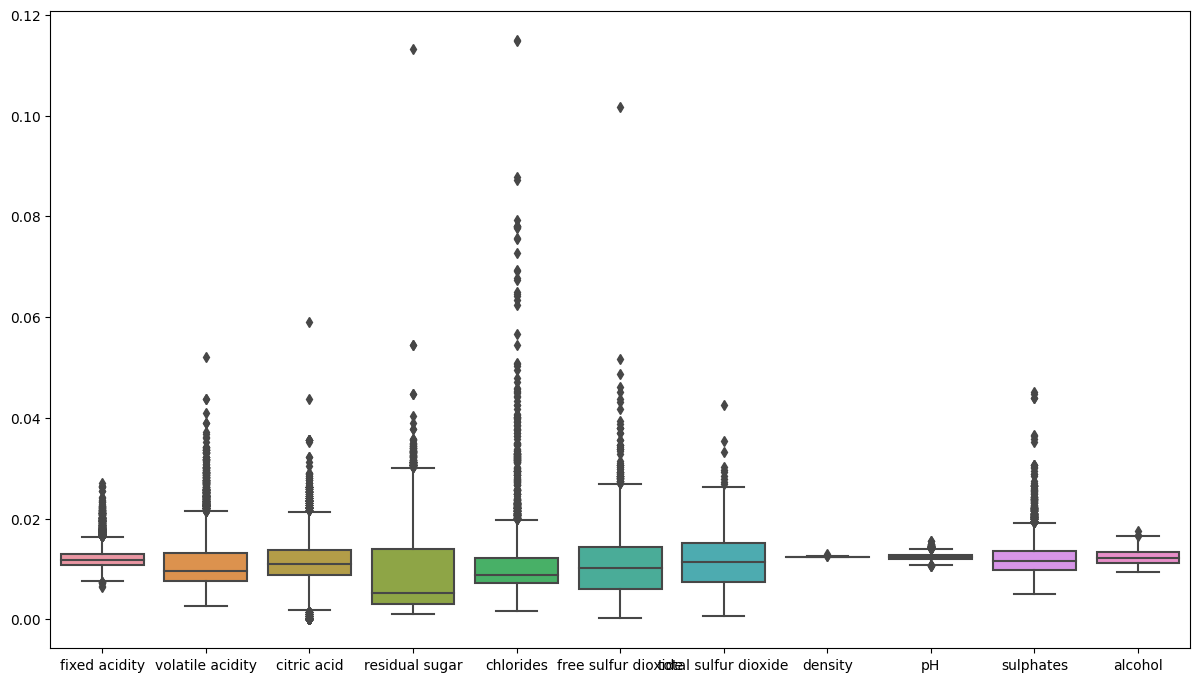

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 14.7,8.27

sns.boxplot(data=df_dnan_norm.iloc[:,0:11])

Удалим выбросы опираясь на z-score. Подберем баланс величины z-score с оглядкой на количество удаляемых объектов в целом и в частности объектов миноритарных классов

In [ ]:
df_dnan_norm_excltarg = df_dnan_norm.iloc[:, :11]

#find absolute value of z-score for each observation
z = np.abs(stats.zscore(df_dnan_norm_excltarg))

#only keep rows in dataframe with all z-scores less than absolute value of 3
dnan_norm_clean = df_dnan_norm_excltarg[(z<4).all(axis=1)]

#find how many rows are left in the dataframe
df_dnan.shape, dnan_norm_clean.shape

((6463, 14), (6275, 11))

In [ ]:
# сформируем 2 общих датасета с двумя вариантами выражения целевой переменной: для модели классификации и модели предсказания значения
df_dnan_norm_clean_enc = dnan_norm_clean.join(encoder_df, how="inner")
df_full = df_dnan_norm_clean_enc.join(df_dnan_norm["quality"], how="inner")
df_full_cattarg = df_dnan_norm_clean_enc.join(df_dnan[["quality"]], how="inner")
# проверим дополнительно результат объединения таблиц подсетом Nan
df_full_cattarg.isnull().sum().sum ()

# сохраним предобработанные данные
df_full_cattarg.to_pickle ("df_full_cattarg.pkl")
df_full.to_pickle ("df_full.pkl")

In [ ]:
df_full_cattarg['quality'].value_counts()

6    2744
5    2059
7    1059
4     200
8     189
3      19
9       5
Name: quality, dtype: int64

<Axes: >

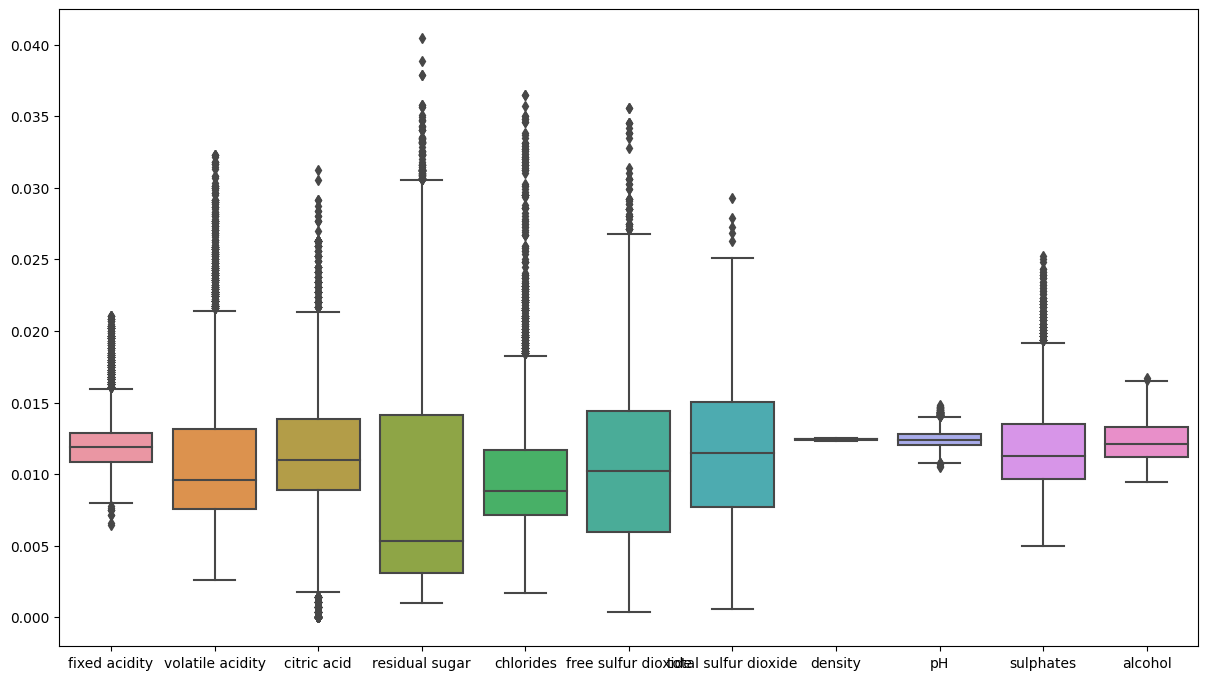

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 14.7,8.27

sns.boxplot(data=df_full.iloc[:,0:11])

Видим что количество выбросов значительно скоратилось. Вместе с этим сократилось и количество объектов миноритарных классов. Дальнейшее удаление выбросов еще сильнее их сокращает поэтом остановимся на текущем значении z-score и выбросы больше не будем удалять.

Попробуем оценить влияние каждого признака на целевой в зависимости от типа вина. Этим оценим целесообразнасть использования каждого признака в обучении моделей.

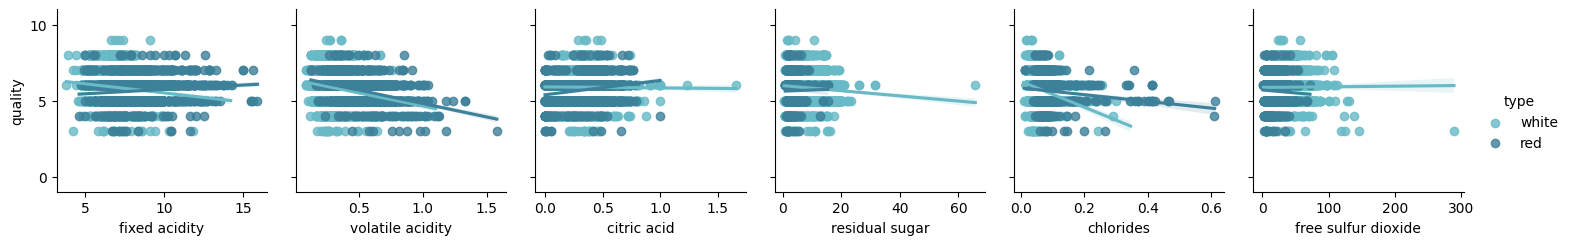

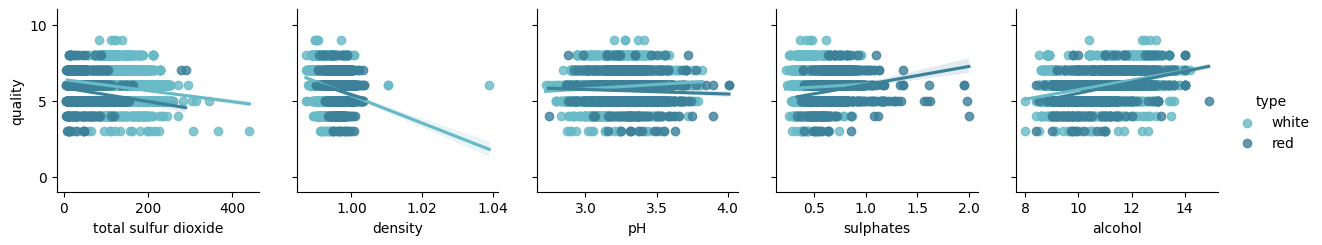

In [ ]:
g = sns.PairGrid(df, y_vars=["quality"], x_vars=list(df)[1:-6],palette="GnBu_d",hue="type")
g.map(sns.regplot)
g.set(ylim=(-1, 11), yticks=[0, 5, 10]);
g.add_legend()
plt.show()

a = sns.PairGrid(df, y_vars=["quality"], x_vars=list(df)[-6:-1],palette="GnBu_d",hue="type")
a.map(sns.regplot)
a.set(ylim=(-1, 11), yticks=[0, 5, 10]);
a.add_legend()
plt.show()

По линиям тренда видим что совсем бесполезных признаков в датасете нет. Всегда присутствует либо положительная, либо отрицательная взаимосвязь с целевой переменной к минимум в одном из типов вина.

<Axes: >

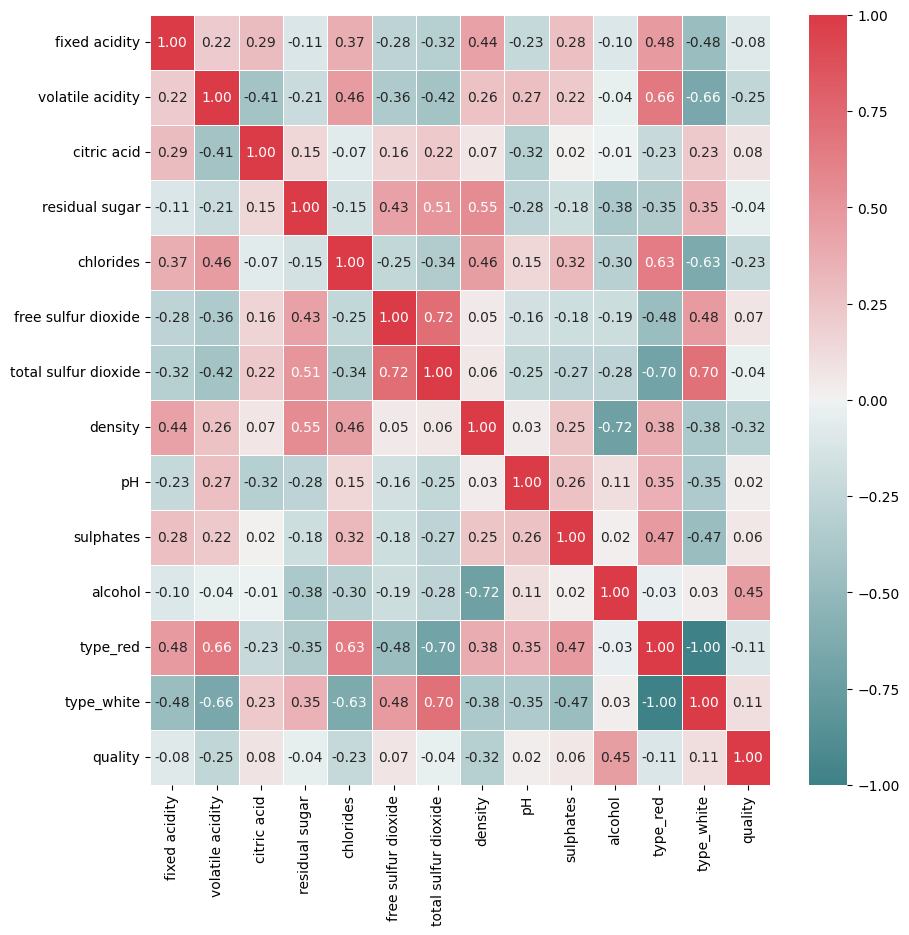

In [ ]:
corr = df_full.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True,cmap=sns.diverging_palette(200, 10, as_cmap=True), vmin=-1, vmax=1, linewidths=.5, fmt=".2f")

По матрице корреляций оценим уже совокупные по типам вина взаимосвязи признаков. Отметим значительную положительную корреляцию quality и alcohol, а также значительную отрицательную density и quality. Также высокую корреляцую между собой имеют free sulfur dioxide и total sulfur dioxide, но ввиду очень низкой корреляции с quality у обоих считать их дублями и удалять чтобы снизить искажение в модели причины нет

Считаем что основная часть исследования и предобработки данных завершена. Сформируем датасеты для обучения и тестирования моделей.

In [ ]:
# split into input (X) and output (Y) variables
X = df_full.iloc[:,0:13]
y = df_full_cattarg['quality']

In [ ]:
X.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.011873,0.008899,0.012784,0.035618,0.008465,0.015854,0.016423,0.012518,0.011581,0.010147,0.010365,0.0,1.0


Перед обучением моделей решим проблему дисбаланса классов с помощью оверсемплинга методом SMOTE. Выровняем количество объектов в классах.

In [ ]:
df_full_cattarg['quality'].value_counts()

6    2744
5    2059
7    1059
4     200
8     189
3      19
9       5
Name: quality, dtype: int64

In [ ]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=4)
X, y = oversample.fit_resample(X, y)

In [ ]:
y.value_counts()

6    2744
5    2744
7    2744
8    2744
4    2744
3    2744
9    2744
Name: quality, dtype: int64

**4. Моделирование**

Считаем подход для решения задачи классификацией основным и выберем модель RandomForestClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Попробуем сразу подобрать самые оптимальные гиперпараметры модели с помощью RandomizedSearchCV

In [ ]:
f= RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(f,
                        param_dist,
                        n_iter = 20,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

**5. Оценка решения**

In [ ]:
y_pred=rs.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       578
           4       0.92      0.95      0.94       528
           5       0.72      0.79      0.75       544
           6       0.73      0.56      0.63       572
           7       0.81      0.86      0.84       561
           8       0.94      0.96      0.95       551
           9       1.00      1.00      1.00       508

    accuracy                           0.87      3842
   macro avg       0.87      0.88      0.87      3842
weighted avg       0.87      0.87      0.87      3842



В отчете по предсказаниям на тестовой выборке видим достаточно высокое значение f1-score, а также неплохие показатели в разрезе классов. Причем f-score растет к "полюсам", т.е. модель отлично видит разницу между хорошим и плохим вином и ей сложнее всего поставить оценку винам среднего качества, которые вероятно обладают либо противоречивым балансом характеристик, либо усредненным что позволяет отнести к любому полюсу и затрудняет оценку. Вместе с этим это также говорит о том, что модели труднее всего отработать на реальных данных, т.к. классы 5,6,7  синтезировались на порядок меньше.

Дополнительно оценим модель с помощью кроссвалидации.

In [ ]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(rs.best_estimator_, X, y, cv=kfold,scoring='accuracy')
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))

Results: 0.88 (0.01) accuracy


В качестве бонуса свойственного деревьям решений посмотрим на важность признаков для точной классификации по оценке модели

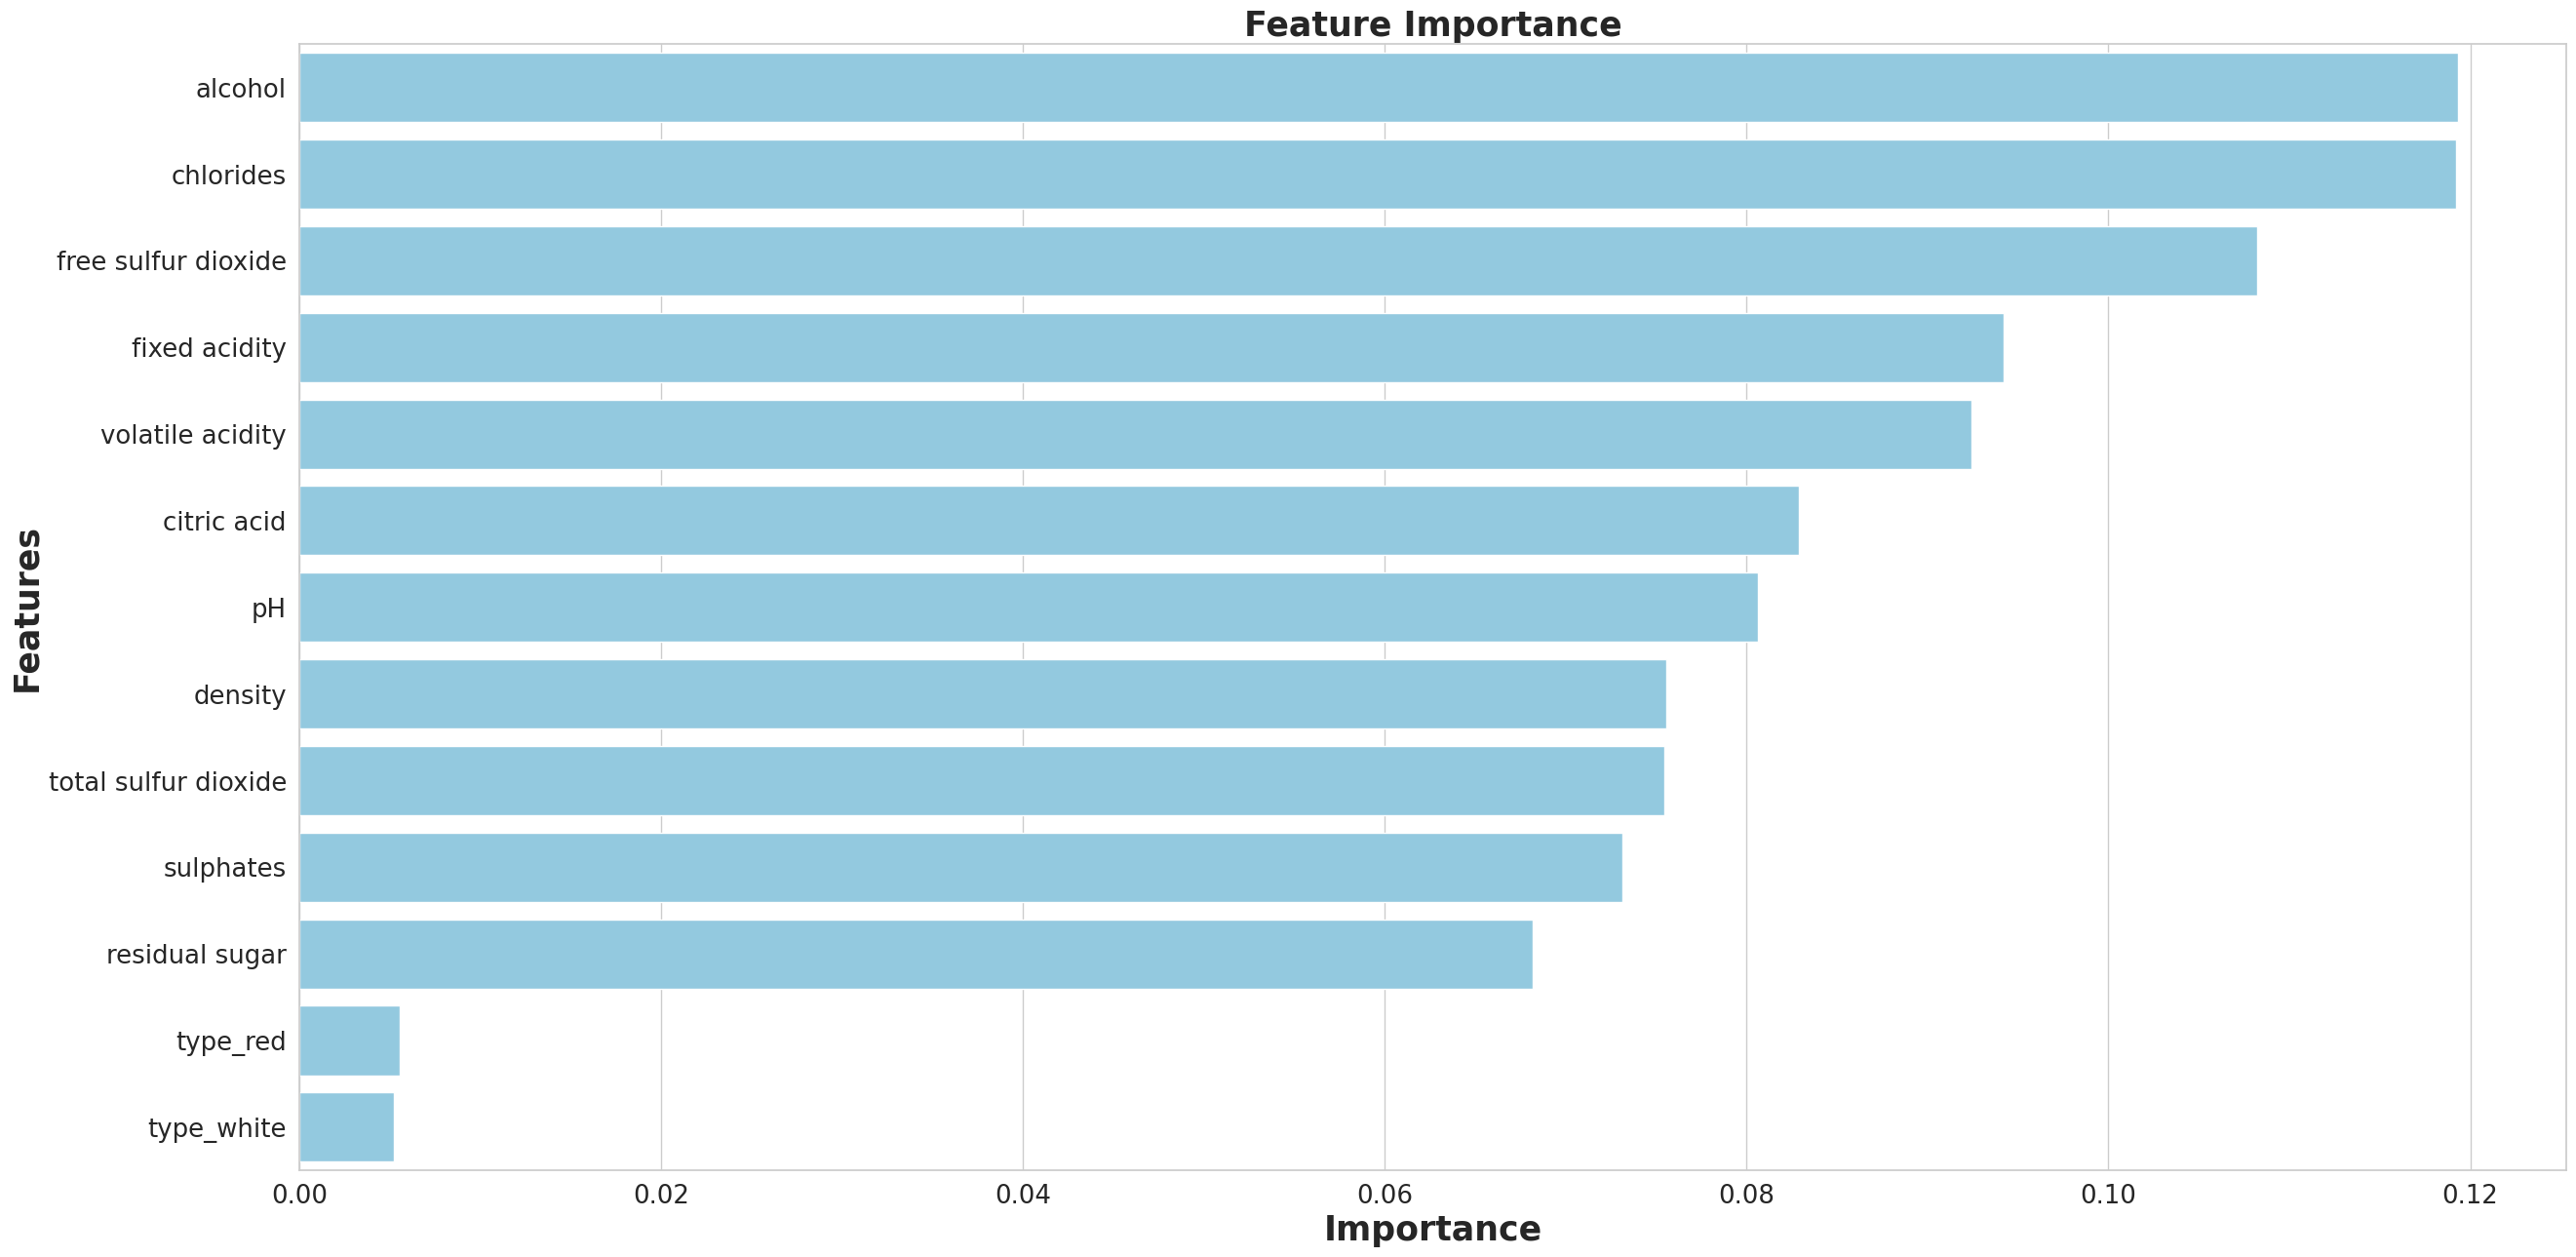

None

,Features,Gini-Importance
0,alcohol,0.119345
1,chlorides,0.119226
2,free sulfur dioxide,0.108206
3,fixed acidity,0.094205
4,volatile acidity,0.092444
5,citric acid,0.082903
6,pH,0.080600
7,density,0.075560
8,total sulfur dioxide,0.075428
9,sulphates,0.073154


In [ ]:
feats = {}
for feature, importance in zip(df_full.iloc[:,0:13].columns, rs.best_estimator_.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Дополнительно попробуем решить задачу с помощью нейросетей.

*спойлер нейронки очень долго учатся, не дождался =)

In [ ]:
#  сохраним предобученную rfc модель для быстрой загрузки в дальнейшем

rf_est = "rf_est_ready_model.pkl"

with open(rf_est, 'wb') as file:
  pickle.dump(rs.best_estimator_, file)

In [ ]:
# Загрузка и проверочный тест предобученной модели

rf_est_ready_model = pickle.load(open("rf_est_ready_model.pkl", 'rb'))
result = rf_est_ready_model.score(X_test, y_test)
print(result)

0.8727225403435711


**keras regressor model**

In [ ]:
y_norm = preprocessing.normalize(y.array.reshape(-1, 1), axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
X.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.011873,0.008899,0.012784,0.035618,0.008465,0.015854,0.016423,0.012518,0.011581,0.010147,0.010365,0.0,1.0


In [ ]:
X.shape

(19208, 13)

In [ ]:
# define the model
def regressor_model():
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=13,activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(32, activation='relu'))
	model.add(Dense(16,activation='relu'))
	model.add(Dense(1, activation='linear'))
	# Compile model
	model.compile(loss="mean_squared_error", optimizer="adam", metrics=['mse', 'mae', 'mape'])
	return model

In [ ]:
regressor_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               1792      
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 16)                528       
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12673 (49.50 KB)
Trainable params: 12673 (49.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
regressor = KerasRegressor(build_fn=regressor_model, epochs=100, batch_size=5, verbose=1)

In [ ]:
regressor.fit(X_train,y_train)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3074/3074 [==============================] - 12s 3ms/step - loss: 1.0334e-05 - mse: 1.0334e-05 - mae: 0.0022 - mape: 39.0543
Epoch 2/100
3074/3074 [==============================] - 11s 3ms/step - loss: 5.3551e-06 - mse: 5.3551e-06 - mae: 0.0019 - mape: 33.3138
Epoch 3/100
3074/3074 [==============================] - 10s 3ms/step - loss: 4.4409e-06 - mse: 4.4409e-06 - mae: 0.0017 - mape: 30.4622
Epoch 4/100
3074/3074 [==============================] - 10s 3ms/step - loss: 3.5592e-06 - mse: 3.5592e-06 - mae: 0.0015 - mape: 26.6849
Epoch 5/100
3074/3074 [==============================] - 11s 3ms/step - loss: 3.2328e-06 - mse: 3.2328e-06 - mae: 0.0015 - mape: 25.2114
Epoch 6/100
3074/3074 [==============================] - 11s 3ms/step - loss: 2.9143e-06 - mse: 2.9143e-06 - mae: 0.0014 - mape: 23.7714
Epoch 7/100
3074/3074 [==============================] - 10s 3ms/step - loss: 2.8471e-06 - mse: 2.8471e-06 - mae: 0.0013 - mape: 23.4164
Epoch 8/100
3074/3074 [==============================

KerasRegressor(
	model=None
	build_fn=<function regressor_model at 0x7dabe589bb50>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

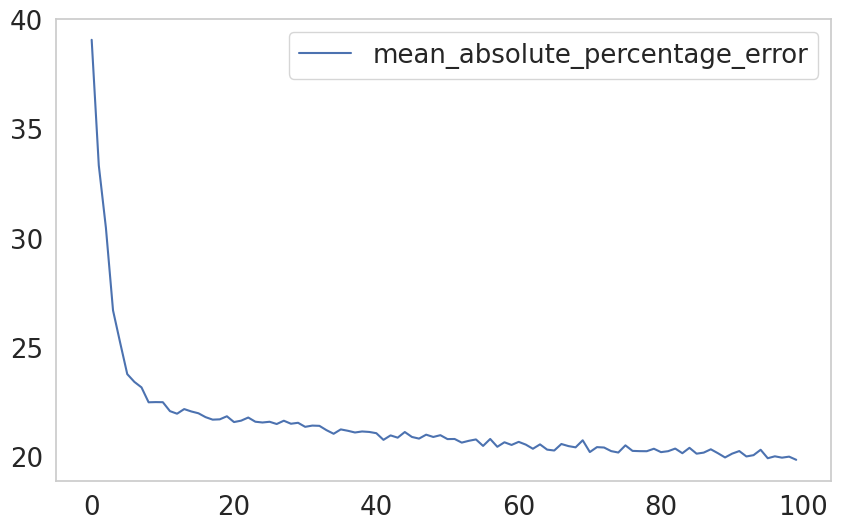

In [ ]:
# plot metrics
rcParams['figure.figsize'] = 10, 6
# plt.plot(regressor.history_['mean_squared_error'], label="mean_squared_error")
# plt.plot(regressor.history_['mean_absolute_error'], label="mean_absolute_error")
plt.plot(regressor.history_['mean_absolute_percentage_error'], label="mean_absolute_percentage_error")
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_pred = regressor.predict(X_test)
mse_krr = mean_squared_error(y_test, y_pred)
print(mse_krr)

769/769 [==============================] - 2s 2ms/step
2.304525111981437e-06


In [ ]:
# сохраним предобученную модель
regressor.model_.save('keras_regressor')

In [4]:
# загрузим предобученную модель
model_loaded_regressor = keras.models.load_model('keras_regressor')

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=regressor_model, epochs=10, batch_size=5, verbose=1)

In [ ]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(estimator, X, y_norm, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3458/3458 [==============================] - 13s 3ms/step - loss: 4.1787 - mse: 4.1787 - mae: 1.7112 - mape: 34.1970
Epoch 2/10
2364/3458 [===================>..........] - ETA: 3s - loss: 2.8578 - mse: 2.8578 - mae: 1.4169 - mape: 28.4665

KeyboardInterrupt: ignored

In [ ]:
results

**keras classifier_model**

In [ ]:
# split into input (X) and output (Y) variables
# X = df_full.iloc[:,0:13]
y = pd.get_dummies(y).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# define the model
def classifier_model():
	# create model
	model = Sequential()
	model.add(Dense(64, input_dim=13,activation='relu'))
	model.add(Dense(32, activation='relu'))
	model.add(Dense(7,activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=["accuracy"])
	return model

In [ ]:
Classifier = KerasClassifier(build_fn=classifier_model, epochs=200, batch_size=5, verbose=1)

In [ ]:
Classifier.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
3074/3074 [==============================] - 11s 3ms/step - loss: 1.9206 - accuracy: 0.1810
Epoch 2/200
3074/3074 [==============================] - 9s 3ms/step - loss: 1.9069 - accuracy: 0.1889
Epoch 3/200
3074/3074 [==============================] - 7s 2ms/step - loss: 1.9049 - accuracy: 0.1877
Epoch 4/200
3074/3074 [==============================] - 8s 3ms/step - loss: 1.9048 - accuracy: 0.1878
Epoch 5/200
3074/3074 [==============================] - 7s 2ms/step - loss: 1.9044 - accuracy: 0.1857
Epoch 6/200
3074/3074 [==============================] - 8s 3ms/step - loss: 1.9043 - accuracy: 0.1874
Epoch 7/200
3074/3074 [==============================] - 7s 2ms/step - loss: 1.9039 - accuracy: 0.1850
Epoch 8/200
3074/3074 [==============================] - 8s 3ms/step - loss: 1.9039 - accuracy: 0.1875
Epoch 9/200
3074/3074 [==============================] - 8s 3ms/step - loss: 1.9038 - accuracy: 0.1888
Epoch 10/200
3074/3074 [==============================] - 7s 2ms/step - 

KerasClassifier(
	model=None
	build_fn=<function classifier_model at 0x7dabf5220a60>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	class_weight=None
)

In [ ]:
y_pred = Classifier.predict(X_test, batch_size=5, verbose=1)

769/769 [==============================] - 4s 5ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.13      0.22       578
           1       0.55      0.31      0.40       528
           2       0.28      0.50      0.36       544
           3       0.29      0.15      0.20       572
           4       0.27      0.11      0.15       561
           5       0.26      0.60      0.36       551
           6       0.44      0.59      0.51       508

   micro avg       0.34      0.34      0.34      3842
   macro avg       0.40      0.34      0.31      3842
weighted avg       0.40      0.34      0.31      3842
 samples avg       0.34      0.34      0.34      3842



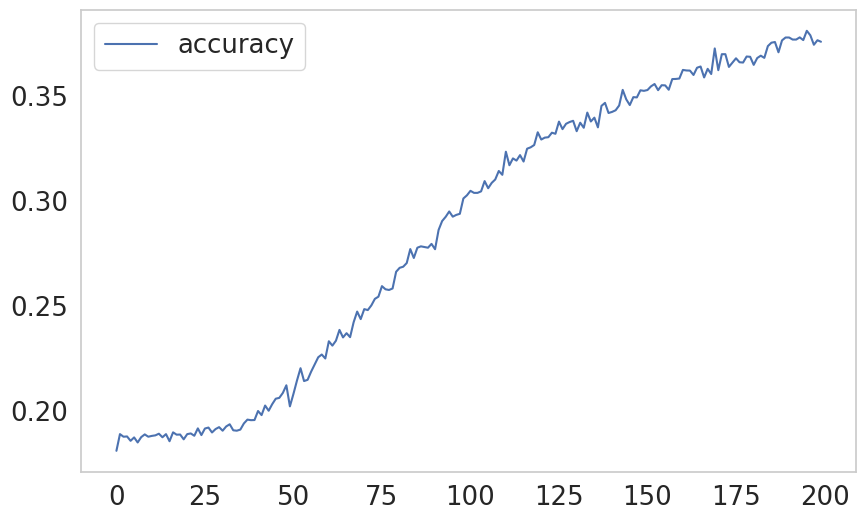

In [ ]:
# plot metrics
rcParams['figure.figsize'] = 10, 6
plt.plot(Classifier.history_['accuracy'], label="accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# сохраним предобученную модель

Classifier.model_.save('keras_Classifier')

In [ ]:
# загрузим предобученную модель

model_loaded_Classifier = keras.models.load_model('keras_Classifier')